In [ ]:
!pip install accelerate -U

In [ ]:
pip show torch


Name: torch
Version: 2.1.0+cu121
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, torchaudio, torchdata, torchtext, torchvision


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, BertForSequenceClassification, pipeline
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch

In [ ]:
df = pd.read_csv("dataset.csv")
df.head()

,page_id,text,label,Pattern Category
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,158,Pillowcases & Shams,0,Not Dark Pattern
2,108,Write a review,0,Not Dark Pattern
3,1425,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,1658,newsletter signup (privacy policy),0,Not Dark Pattern


In [ ]:
(df.isna().sum())

page_id             0
text                0
label               0
Pattern Category    0
dtype: int64

In [ ]:
fine = df['Pattern Category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [ ]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [ ]:
id2fine

{0: 'Urgency',
 1: 'Not Dark Pattern',
 2: 'Scarcity',
 3: 'Misdirection',
 4: 'Social Proof',
 5: 'Obstruction',
 6: 'Sneaking',
 7: 'Forced Action'}

In [ ]:
fine2id

{'Urgency': 0,
 'Not Dark Pattern': 1,
 'Scarcity': 2,
 'Misdirection': 3,
 'Social Proof': 4,
 'Obstruction': 5,
 'Sneaking': 6,
 'Forced Action': 7}

In [ ]:
df.drop('label', axis=1, inplace=True)

In [ ]:
df.head()

,page_id,text,Pattern Category
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,158,Pillowcases & Shams,Not Dark Pattern
2,108,Write a review,Not Dark Pattern
3,1425,"To start your return, simply click on the foll...",Not Dark Pattern
4,1658,newsletter signup (privacy policy),Not Dark Pattern


In [ ]:
df['labels']=df['Pattern Category'].map(lambda x: fine2id[x.strip()])

In [ ]:
df

,page_id,text,Pattern Category,labels
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,158,Pillowcases & Shams,Not Dark Pattern,1
2,108,Write a review,Not Dark Pattern,1
3,1425,"To start your return, simply click on the foll...",Not Dark Pattern,1
4,1658,newsletter signup (privacy policy),Not Dark Pattern,1
...,...,...,...,...
2350,1304,Bra Panty Set,Not Dark Pattern,1
2351,1038,DressesFootwearHatsHoodies & SweatshirtsJersey...,Not Dark Pattern,1
2352,1081,Only 4 left in stock,Scarcity,2
2353,767,Trending Players,Not Dark Pattern,1


<Axes: ylabel='Pattern Category'>

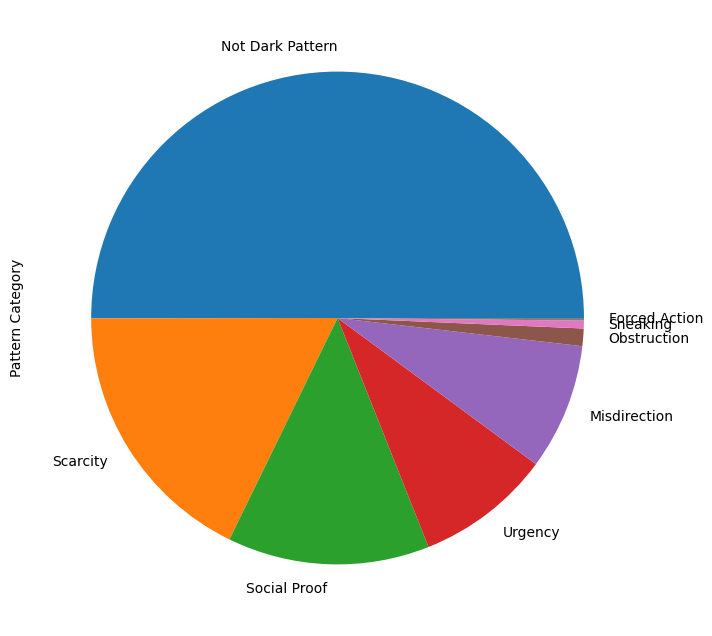

In [ ]:
df['Pattern Category'].value_counts().plot(kind='pie', figsize=(8,8))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_fine,
                                                      id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2:(3*SIZE)//4])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])

In [ ]:
len(train_texts), len(val_texts), len(test_texts)

(1177, 589, 589)

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
if len(val_texts) > 0:
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
else:
    val_encodings = None  # or handle it accordingly)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [ ]:
pip install accelerate -U

In [ ]:
pip install transformers[torch]

In [ ]:
!pip show accelerate

Name: accelerate
Version: 0.26.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [ ]:
pip install accelerate==0.20.1


  Using cached accelerate-0.20.1-py3-none-any.whl (227 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1


In [ ]:
!pip install transformers -U
!pip install accelerate -U

  Using cached accelerate-0.26.1-py3-none-any.whl (270 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.1
    Uninstalling accelerate-0.20.1:
      Successfully uninstalled accelerate-0.20.1


In [ ]:
!pip install sentencepiece

In [ ]:
from transformers import TrainingArguments

In [ ]:
training_args = TrainingArguments(
    output_dir="./TTC4908Model",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.936800,0.684378,0.860781,0.568339,0.632386,0.552174
100,0.351400,0.293324,0.926995,0.651413,0.669940,0.640439
150,0.204900,0.225757,0.940577,0.715208,0.821739,0.683985
200,0.082500,0.197166,0.962649,0.810960,0.824666,0.799105


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=222, training_loss=0.36386224224760727, metrics={'train_runtime': 120.9295, 'train_samples_per_second': 29.199, 'train_steps_per_second': 1.836, 'total_flos': 295786162604592.0, 'train_loss': 0.36386224224760727, 'epoch': 3.0})

In [ ]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs['logits'].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label

    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
model_path = "DPBH_BERT_Fine_Tuned_Model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)


('DPBH_BERT_Fine_Tuned_Model/tokenizer_config.json',
 'DPBH_BERT_Fine_Tuned_Model/special_tokens_map.json',
 'DPBH_BERT_Fine_Tuned_Model/vocab.txt',
 'DPBH_BERT_Fine_Tuned_Model/added_tokens.json',
 'DPBH_BERT_Fine_Tuned_Model/tokenizer.json')

In [ ]:
# Reload the model
from transformers import BertTokenizerFast

model_path = "DPBH_BERT_Fine_Tuned_Model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
nlp("Haris just bought an airplane at just rs 99")

[{'label': 'Social Proof', 'score': 0.9906790852546692}]

In [ ]:
nlp("Unlock the full experience by clicking 'Upgrade Now' and leave behind the limitations of the standard version – your journey to superior benefits begins here!")

[{'label': 'Not Dark Pattern', 'score': 0.681275486946106}]